In [1]:
%matplotlib inline

import cv2
import functools as ft
import itertools as it
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import operator as op
import pickle
import random
import sys
import hdbscan
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler

def show_and_wait(frame, title='tesst'):
    cv2.imshow(title, frame)
    return chr(cv2.waitKey(0))

def read_and_wait(video, title='tesst'):
    result, frame = video.read()
    if result:
        return show_and_wait(frame, title)

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = it.tee(iterable)
    next(b, None)
    return zip(a, b)

def construct_data(file_path, extent, known_file_path=None, known_frame=-1, modify_frame=None):
    start_at = datetime.now()
    video = cv2.VideoCapture(file_path, cv2.CAP_MSMF)
    print(video.get(cv2.CAP_PROP_FRAME_COUNT), video.get(cv2.CAP_PROP_FPS))
    n = min(max(1, round(video.get(cv2.CAP_PROP_FRAME_COUNT) / 2000)), 30)
    top, left, bottom, right = extent
    def fn(frame):
        frame = frame[top:bottom, left:right]
        return modify_frame(frame) if modify_frame else frame
    def yield_frames():
        while True:
            result, frame = video.read()
            if not result:
                break
            yield frame
    frames = [fn(f) for i, f in enumerate(yield_frames()) if i % n == 0]
    video.release()

    if known_file_path:
        # Add a known positive frame.
        video = cv2.VideoCapture(known_file_path, cv2.CAP_MSMF)
        print(video.get(cv2.CAP_PROP_FRAME_COUNT), video.get(cv2.CAP_PROP_FPS))
        print(video.set(cv2.CAP_PROP_POS_FRAMES, video.get(cv2.CAP_PROP_FRAME_COUNT) if known_frame < 0 else known_frame))
        _, frame = video.read()
        frames.append(fn(frame))
        video.release()

    data = StandardScaler().fit_transform(np.stack([f.reshape(-1) for f in frames]))
    print(data.shape)
    print('total time:', (datetime.now() - start_at).total_seconds(), 'seconds')
    return frames, data

def print_clusters(frames, cluster_labels, has_known_cluster=False):
    print('cluster count:', len(np.unique(cluster_labels)))
    print(np.unique(cluster_labels))
    print(cluster_labels[:22])
    print(*enumerate(cluster_labels[:22]))
    print(*((k, len(list(v))) for k, v in it.groupby(np.sort(cluster_labels))))
    if has_known_cluster:
        if cluster_labels[-1] < 0:
            print('desired cluster unknown')
        else:
            print('desired cluster:', cluster_labels[-1])
    def fn():
        for n in np.unique(cluster_labels):
            g = (i for i, j in enumerate(cluster_labels) if j == n)
            g = it.islice(g, 5)
            stack = [frames[i] for i in g]
            yield np.hstack(stack)
    #plt.imshow(np.vstack(list(fn())).take([2,1,0], axis=2))
    plt.imshow(cv2.cvtColor(np.vstack(list(fn())), cv2.COLOR_BGR2RGB))

def predict_cluster_labels(data, min_cluster_size=22):
    start_at = datetime.now()
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    cluster_labels = clusterer.fit_predict(data)
    print('total time:', (datetime.now() - start_at).total_seconds(), 'seconds')
    return cluster_labels

In [9]:
# This is a test for Legends clustering.
# This takes about 70 seconds to run.
#frames, data = construct_data(r"C:\Users\cidzerda\Documents\GitHub\strevr-data\legends\thefyzu.mp4", (426, 42, 456, 77))
# This takes about 35 seconds to run.
frames, data = construct_data(r"C:\Users\cidzerda\Documents\GitHub\strevr-data\tesst\telshin1-cglrw.mp4", (426, 42, 456, 77))

30000.0 30.0
(2000, 3150)
total time: 34.15113 seconds


In [10]:
# This takes about 20 seconds to run.
cluster_labels = predict_cluster_labels(data)

total time: 19.167177 seconds


cluster count: 14
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
(0, 2) (1, 2) (2, 2) (3, 2) (4, 2) (5, 2) (6, 2) (7, 2) (8, 2) (9, 2) (10, 2) (11, 2) (12, 2) (13, 2) (14, 2) (15, 2) (16, 2) (17, 2) (18, 2) (19, 2) (20, 2) (21, 2)
(-1, 233) (0, 250) (1, 337) (2, 175) (3, 191) (4, 235) (5, 395) (6, 28) (7, 29) (8, 22) (9, 27) (10, 31) (11, 25) (12, 22)


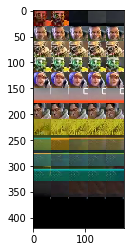

In [11]:
print_clusters(frames, cluster_labels)

In [12]:
# This is a test for Idle clustering.
# This takes about 75 seconds to run.
file_path = r"C:\Users\cidzerda\Documents\GitHub\strevr-data\idle\vsnz1.mp4"
known_file_path = r"C:\Users\cidzerda\Documents\GitHub\strevr-data\legends\nikolarn.mp4"
def modify_frame(frame):
    return cv2.resize(frame, (0, 0), fx=.25, fy=.25, interpolation=cv2.INTER_AREA)
frames, data = construct_data(file_path, (0, 139, 39, 265), known_file_path=known_file_path, modify_frame=modify_frame)

66062.0 30.063524226690998
8842.0 30.049341017951477
True
(2204, 960)
total time: 75.519051 seconds


In [13]:
# This takes about 7 seconds to run.
cluster_labels = predict_cluster_labels(data)

total time: 7.129998 seconds


cluster count: 4
[-1  0  1  2]
[ 1 -1  1  1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1  1 -1 -1  1  1]
(0, 1) (1, -1) (2, 1) (3, 1) (4, 1) (5, 1) (6, 1) (7, -1) (8, -1) (9, 1) (10, 1) (11, 1) (12, 1) (13, -1) (14, 1) (15, 1) (16, 1) (17, 1) (18, -1) (19, -1) (20, 1) (21, 1)
(-1, 388) (0, 28) (1, 1535) (2, 253)
desired cluster: 2


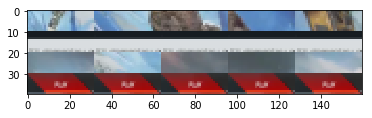

In [14]:
print_clusters(frames, cluster_labels, True)

In [2]:
# This is a test for Champion clustering.
# This takes about 7 seconds to run.
file_path = r"C:\Users\cidzerda\Documents\GitHub\strevr-data\tesst\staycationyoutube1.mp4"
known_file_path = r"C:\Users\cidzerda\Documents\GitHub\strevr-data\champion\xednim.mp4"
def modify_frame(frame):
    return cv2.resize(frame, (0, 0), fx=.25, fy=.25, interpolation=cv2.INTER_AREA)
frames, data = construct_data(file_path, (184, 213, 259, 621), known_file_path=known_file_path, modify_frame=modify_frame)

5845.0 29.229851863110756
23522.0 29.97002997002997
True
(1950, 5814)
total time: 7.289964 seconds


In [3]:
# This takes about 40 seconds to run.
cluster_labels = predict_cluster_labels(data)

total time: 37.988181 seconds


cluster count: 13
[-1  0  1  2  3  4  5  6  7  8  9 10 11]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8  8  8  8  8  8  8]
(0, -1) (1, -1) (2, -1) (3, -1) (4, -1) (5, -1) (6, -1) (7, -1) (8, -1) (9, -1) (10, -1) (11, -1) (12, -1) (13, -1) (14, -1) (15, 8) (16, 8) (17, 8) (18, 8) (19, 8) (20, 8) (21, 8)
(-1, 750) (0, 50) (1, 124) (2, 193) (3, 62) (4, 30) (5, 26) (6, 83) (7, 45) (8, 472) (9, 26) (10, 23) (11, 66)
desired cluster: 1


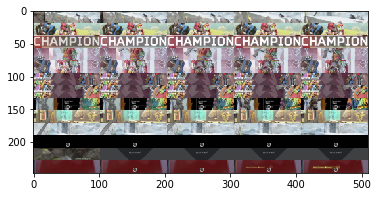

In [4]:
print_clusters(frames, cluster_labels, True)